# HelioCloud + SDO

- https://github.com/heliocloud-data/science-tutorials/blob/main/SDO-Demo.ipynb

In [ ]:
import cloudcatalog
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import dask
import io
import logging
import time
import re
import pickle
import astropy.io.fits

## HelioCloud shared cloud file registry (cloudcatalog)

This is a simple standard for any dataset that enables users to access it via an API or directly. The short definition is: * S3 disks have a 'catalog.json' describing their datasets * Each dataset has a _YYYY.csv index file of its contents * These indexes have the form "time, s3_location, filesize" (plus optional metadata)

Let's walk through this.

## List of all known 'catalogs'

In [ ]:
# this is pre-release so the main registry is on a temporary site
cr = cloudcatalog.CatalogRegistry()

# Let us see which clouds are known to the HelioCloud network
cat = cr.get_catalog()
print("List of clouds via get_catalog",cat,'\n')
reg = cr.get_registry()
print("Or just the S3 endpoints via get_registry:",reg,'\n')
link = cr.get_entries()
print("get_entries:",link,'\n')

# Now let us grab the specific cloud containing SDO
url = cr.get_endpoint("HelioCloud, including SDO")
print("SDO result for get_endpoint:",url)

List of clouds via get_catalog {'version': '0.4', 'modification': '2022-01-01T00:00Z', 'registry': [{'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}]} 

Or just the S3 endpoints via get_registry: [{'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}] 

get_entries: {'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'} 

SDO result for get_endpoint: s3://gov-nasa-hdrl-data1/


## For a given S3 location, list available datasets

In [ ]:
fr = cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")
entries_dict = fr.get_entries_dict()
print("Showing first 10 of", len(entries_dict),"datasets at this HDRL S3:\n",entries_dict[:10])

Showing first 10 of 1743 datasets at this HDRL S3:
 [{'id': 'aia_0094', 'title': 'AIA 0094 FITS data', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'start': '2010-05-13T00:00:00Z', 'stop': '2022-12-31T23:56:00Z', 'modification': '2023-05-04T00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}, {'id': 'aia_0131', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0131 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': '2023-05-04:00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}, {'id': 'aia_0171', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0171 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': '2023-05-04:00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}, {'id': 'aia_0193', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0193 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': 

In [ ]:
# Now we get metadata associated with AIA 94A
frID = "aia_0094"
myjson = fr.get_entry(frID)
start, stop = myjson['start'], myjson['stop']
print(frID,start,stop)

aia_0094 2010-05-13T00:00:00Z 2022-12-31T23:56:00Z


## Optionally you can choose a subsetted time range (faster testing)

In [ ]:
subset = True
if subset: start, stop = '2020-01-01T00:00:00Z', '2020-12-31T23:59:59Z'

## Now let us get the entire list of SDO files for that AIA ID

In [ ]:
file_registry1 = fr.request_cloud_catalog(frID, start_date=start, stop_date=stop, overwrite=False)
# And convert that richer data to a list of files to process
filelist = file_registry1['datakey'].to_list()

In [ ]:
file_registry1

,start,stop,datakey,filesize
0,2020-02-17 00:00:00,2020-02-17 00:00:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
1,2020-02-17 00:04:00,2020-02-17 00:04:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
2,2020-02-17 00:08:00,2020-02-17 00:08:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
3,2020-02-17 00:12:00,2020-02-17 00:12:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
4,2020-02-17 00:16:00,2020-02-17 00:16:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
...,...,...,...,...
129753,2020-02-16 23:40:00,2020-02-16 23:40:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13913280
129754,2020-02-16 23:44:00,2020-02-16 23:44:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13910400
129755,2020-02-16 23:48:00,2020-02-16 23:48:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13910400
129756,2020-02-16 23:52:00,2020-02-16 23:52:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13913280


## Actual Analysis code

Here's our analysis routines, that operate on a single FITS file and returns the results of our 'work_on_data()' function.

In [ ]:
def DO_SCIENCE(mydata):
    # you can put better science here
    iirad = mydata.mean()
    return iirad

# these are variable helpful handler functions
def s3url_to_bucketkey(s3url: str): # -> Tuple[str, str]:
    """
    Extracts the S3 bucket name and file key from an S3 URL.
    e.g. s3://mybucket/mykeypart1/mykeypart2/fname.fits -> mybucket, mykeypart1/mykeypart2/fname.fits
    """
    name2 = re.sub(r"s3://","",s3url)
    s = name2.split("/",1)
    return s[0], s[1]

def process_fits_s3(s3key:str): # -> Tuple[str, float]:
    """ For a single FITS file, read it from S3, grab the header and
        data, then do the DO_SCIENCE() call of choice
    """
    sess = boto3.session.Session() # do this each open to avoid thread problem 'credential_provider'
    # s3c = sess.client("s3")
    s3c = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    mybucket,mykey = s3url_to_bucketkey(s3key)
    try:
        fobj = s3c.get_object(Bucket=mybucket,Key=mykey)
        rawdata = fobj['Body'].read()
        bdata = io.BytesIO(rawdata)
        hdul = astropy.io.fits.open(bdata,memmap=False)        
        date = hdul[1].header['T_OBS']
        irrad = DO_SCIENCE(hdul[1].data)
    except:
        print("Error fetching ",s3key)
        date, irrad = None, None
        
    return date, irrad

In [ ]:
# Serial test it on the first ten files, so slow
res = []
now=time.time()
for i in range(10):
    results = process_fits_s3(filelist[i])
    print(results)
    res.append(results)
print(time.time()-now)

('2020-02-17T00:00:00.572', 1.14938653)
('2020-02-17T00:04:00.566', 1.14467738)
('2020-02-17T00:08:00.565', 1.14912166)
('2020-02-17T00:12:00.581', 1.15062206)
('2020-02-17T00:16:00.565', 1.15031615)
('2020-02-17T00:20:00.566', 1.14179095)
('2020-02-17T00:24:00.588', 1.14150782)
('2020-02-17T00:28:00.572', 1.14470468)
('2020-02-17T00:32:00.588', 1.15231304)
('2020-02-17T00:36:00.572', 1.14333933)
44.57813858985901


In [ ]:
from datetime import datetime

In [ ]:
datetime_objects = [datetime.fromisoformat(ts) for ts in np.array(res)[:, 0]]

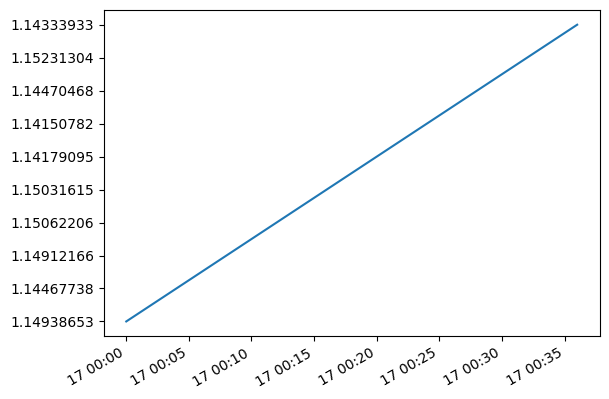

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.plot(datetime_objects, np.array(res)[:, 1])
fig.autofmt_xdate()

In [ ]:
s3c = boto3.client('s3', config=Config(signature_version=UNSIGNED))
mybucket,mykey = s3url_to_bucketkey(filelist[0])
fobj = s3c.get_object(Bucket=mybucket,Key=mykey)
rawdata = fobj['Body'].read()
bdata = io.BytesIO(rawdata)
data = astropy.io.fits.open(bdata,memmap=False)        
data.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    171   (5000, 5000)   int32 (rescales to float64)   


In [ ]:
import s3fs
fs=s3fs.S3FileSystem(anon=True)
fgrab = fs.open(filelist[0])
hdul = astropy.io.fits.open(fgrab)
hdul.info()

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    171   (5000, 5000)   int32 (rescales to float64)   


In [ ]:
np.allclose(data[1].data, hdul[1].data)

True

In [ ]:
from sunpy.map import Map

In [ ]:
smap = Map((hdul[1].data, hdul[1].header))

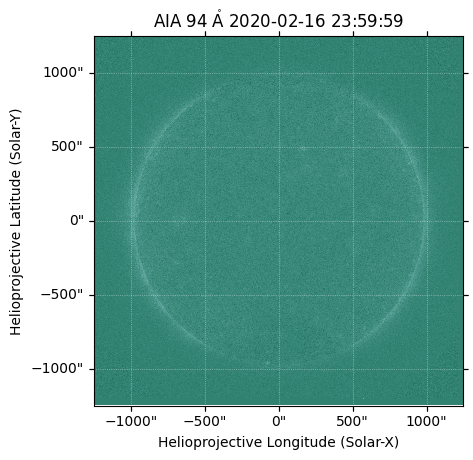

In [ ]:
smap.plot();

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,94.0 Angstrom
Wavelength,94.0 Angstrom
Observation Date,2020-02-16 23:59:59
Exposure Time,2.902045 s
Dimension,[5000. 5000.] pix
Coordinate System,helioprojective
Scale,[0.5 0.5] arcsec / pix
Reference Pixel,[2499.5 2499.5] pix

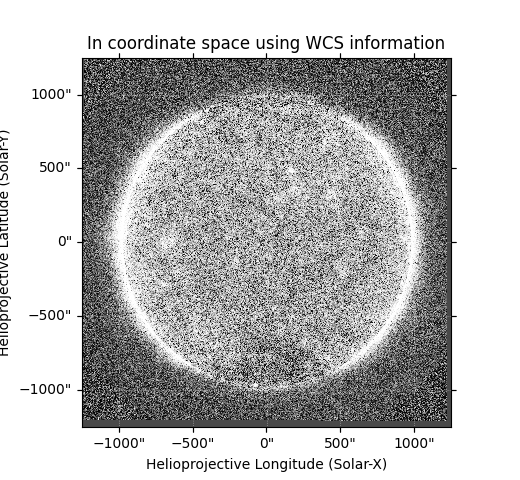
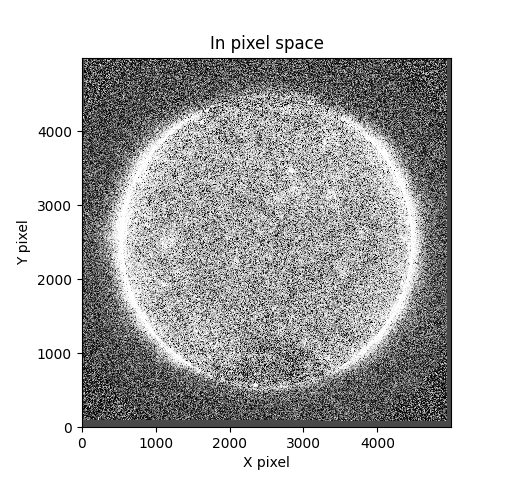
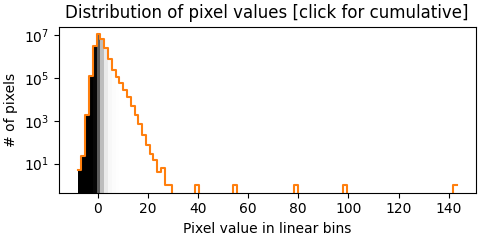
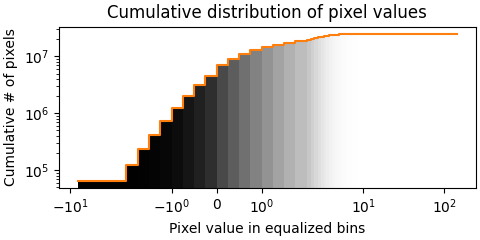

In [ ]:
smap